# VAT Qwen2.5vl:7B LoRA fine-tune
* step 0. Environment Preparation
* step 1. Unsloth Processing
* step 2. VAT Dataset
* step 3. Training the Model
* step 4. Inference Test
* step 5. Evaluation
* step 6. Save Fine-tune Model
* (other step) Convert to GGUF file

## step 0. Environment Preparation

In [1]:
# <<< 在最檔案一開始就放 >>>
import os, pathlib

# 1) 指到很短、你有讀寫權限且不會被清的路徑
SHORT_TORCHINDUCTOR = r"C:\\ti"
SHORT_TRITON        = r"C:\\tc"
SHORT_CUDA_CACHE    = r"C:\\nvc"
SHORT_TMP           = r"C:\\t"

for p in [SHORT_TORCHINDUCTOR, SHORT_TRITON, SHORT_CUDA_CACHE, SHORT_TMP]:
    pathlib.Path(p).mkdir(parents=True, exist_ok=True)

# 2) 設定 cache 與臨時目錄
os.environ["TORCHINDUCTOR_CACHE_DIR"] = SHORT_TORCHINDUCTOR
os.environ["TRITON_CACHE_DIR"]        = SHORT_TRITON
os.environ["CUDA_CACHE_PATH"]         = SHORT_CUDA_CACHE
os.environ["TEMP"] = os.environ["TMP"] = SHORT_TMP

import sys, torch
print(sys.executable)
print(torch.__version__, torch.version.cuda, torch.cuda.is_available())


c:\Users\user\anaconda3\envs\VAT\python.exe
2.8.0+cu126 12.6 True


## step 1. Unsloth Processing

訓練配置小抄（LoRA/QLoRA, 7B 級）:
1. 小數據（≤1k）：降低學習率、增強正則（weight decay/label smoothing）、更小 LoRA r（如 8–16）、強早停。
2. 中等數據（1k–10k）：r=16–32、2–3 個 epoch 足夠；混合精度 + 梯度累積。
3. 大數據（>10k）：考慮 curriculum（先易後難）、分層凍結逐步解凍。

一句話總結：先用 200/800/3k 做學習曲線找拐點，拐點前先擴量，拐點後先提品質與約束；分類通常 1k 左右就穩，欄位抽取與多模態常需要 3k–10k 才「耐用」。

In [2]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Llama-3.2-11B-Vision-Instruct-bnb-4bit", # Llama 3.2 vision support
    "unsloth/Llama-3.2-11B-Vision-bnb-4bit",
    "unsloth/Llama-3.2-90B-Vision-Instruct-bnb-4bit", # Can fit in a 80GB card!
    "unsloth/Llama-3.2-90B-Vision-bnb-4bit",

    "unsloth/Pixtral-12B-2409-bnb-4bit",              # Pixtral fits in 16GB!
    "unsloth/Pixtral-12B-Base-2409-bnb-4bit",         # Pixtral base model

    "unsloth/Qwen2-VL-2B-Instruct-bnb-4bit",          # Qwen2 VL support
    "unsloth/Qwen2-VL-7B-Instruct-bnb-4bit",
    "unsloth/Qwen2-VL-72B-Instruct-bnb-4bit",

    "unsloth/llava-v1.6-mistral-7b-hf-bnb-4bit",      # Any Llava variant works!
    "unsloth/llava-1.5-7b-hf-bnb-4bit",
] # More models at https://huggingface.co/unsloth

model_id = "unsloth/Qwen2.5-VL-7B-Instruct-bnb-4bit" # 原本是 "unsloth/Qwen2.5-VL-7B-Instruct-bnb-4bit", "unsloth/Qwen2.5-VL-3B-Instruct-bnb-4bit"

model, tokenizer = FastVisionModel.from_pretrained(
    model_id,
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

c:\Users\user\anaconda3\envs\VAT\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Exception in thread Thread-4 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\user\anaconda3\envs\VAT\Lib\threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "c:\Users\user\anaconda3\envs\VAT\Lib\site-packages\ipykernel\ipkernel.py", line 772, in run_closure
    _threading_Thread_run(self)
  File "c:\Users\user\anaconda3\envs\VAT\Lib\threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\user\anaconda3\envs\VAT\Lib\subprocess.py", line 1599, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "<frozen codecs>", line 322, in decode
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xa4 in position 7: invalid start byte


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


W0924 11:59:05.824000 36064 site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


🦥 Unsloth Zoo will now patch everything to make training faster!


c:\Users\user\anaconda3\envs\VAT\Lib\site-packages\unsloth_zoo\gradient_checkpointing.py:339: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\c10/cuda/CUDAAllocatorConfig.h:35.)
  GPU_BUFFERS = tuple([torch.empty(2*256*2048, dtype = dtype, device = f"{DEVICE_TYPE}:{i}") for i in range(n_gpus)])


==((====))==  Unsloth 2025.9.4: Fast Qwen2_5_Vl patching. Transformers: 4.56.1.
   \\   /|    NVIDIA GeForce RTX 4070. Num GPUs = 1. Max memory: 11.994 GB. Platform: Windows.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 8.9. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Fetching 2 files: 100%|██████████| 2/2 [00:00<?, ?it/s]


In [3]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 16,           # ** The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)

## step 2. VAT Dataset

In [4]:
from datasets import load_dataset

dataset_path = "C:/Users/user/pythonproject/AllDataset/VAT-OCR/"

dataset = load_dataset("json", data_files=dataset_path+"train2_donut_dataset.json", split="train")

In [5]:
dataset

Dataset({
    features: ['image_path', 'ground_truth'],
    num_rows: 1108
})

triple_invoice/image/192.jpg


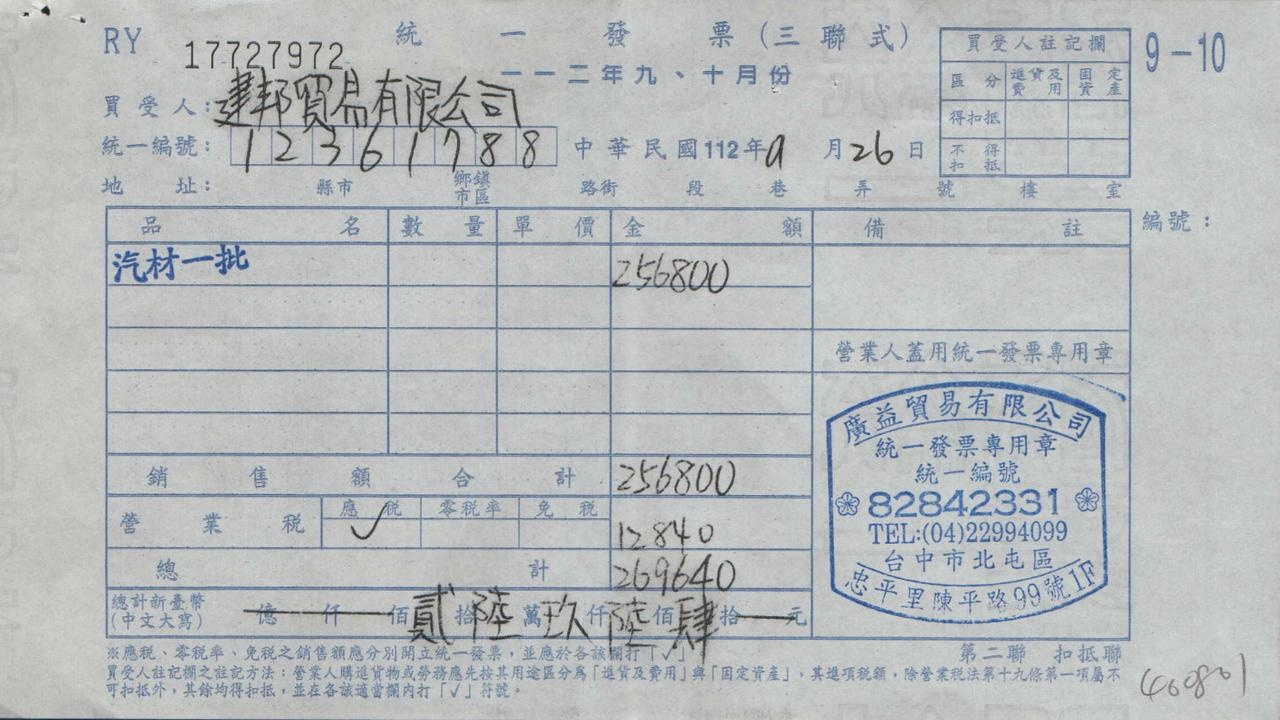

In [6]:
from PIL import Image
index = 10
print(dataset[index]["image_path"])
image = Image.open(dataset_path+dataset[index]["image_path"]).convert("RGB")
image

In [7]:
dataset[index]["ground_truth"]

{'gt_parse': {'Abstract': '汽材一批 256800',
  'BuyerName': '建邦貿易有限公司',
  'BuyerTaxIDNumber': '12361788',
  'CompanyAddress': '台中市北屯區忠平里陳平路99號1F',
  'CompanyName': '廣益貿易有限公司',
  'CompanyTaxIDNumber': '82842331',
  'Doc_class': 'triple_invoice',
  'InvoiceDay': '26',
  'InvoiceMonth': '9',
  'InvoiceNumber': '17727972',
  'InvoiceYear': '112',
  'PhoneNumber': '(04)22994099',
  'PrefixTwoLetters': 'RY',
  'Rationale': '統一發票(三聯式)',
  'SalesTax': '12840',
  'SalesTotalAmount': '256800',
  'TotalAmount': '269640'}}

In [8]:
dataset_path = "C:/Users/user/pythonproject/AllDataset/VAT-OCR/"
instruction = "你是發票/單據分類器與結構化抽取器，請辨識這張文件"

def convert_to_conversation(sample):
    image = Image.open(dataset_path+sample["image_path"]).convert("RGB")
    conversation = [
        { "role": "user",
          "content" : [
            {"type" : "text",  "text"  : instruction},
            {"type" : "image", "image" : image} ]
        },
        { "role" : "assistant",
          "content" : [
            {"type" : "text",  "text"  : sample["ground_truth"]} ]
        },
    ]
    return { "messages" : conversation }
pass

In [9]:
converted_dataset = [convert_to_conversation(sample) for sample in dataset]
converted_dataset[3]

{'messages': [{'role': 'user',
   'content': [{'type': 'text', 'text': '你是發票/單據分類器與結構化抽取器，請辨識這張文件'},
    {'type': 'image',
     'image': <PIL.Image.Image image mode=RGB size=1280x720>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': {'gt_parse': {'Abstract': '汽車零件一批 4600',
       'BuyerName': '建邦貿易有限公司',
       'BuyerTaxIDNumber': '12361788',
       'CompanyAddress': '高雄市武雅區建國一路72巷8號1樓',
       'CompanyName': '日誠興業有限公司',
       'CompanyTaxIDNumber': '90654971',
       'Doc_class': 'triple_invoice',
       'InvoiceDay': '30',
       'InvoiceMonth': '4',
       'InvoiceNumber': '03147223',
       'InvoiceYear': '112',
       'PhoneNumber': '(07)7521765',
       'PrefixTwoLetters': 'KY',
       'Rationale': '統一發票(三聯式)',
       'SalesTax': '230',
       'SalesTotalAmount': '4600',
       'TotalAmount': '4830'}}}]}]}

## step 2.5. Inference before Training

In [10]:
from PIL import Image

FastVisionModel.for_inference(model) # Enable for inference!

# image = dataset[2]["image"]
image = Image.open(dataset_path+dataset[index]["image_path"]).convert("RGB")

#instruction = "Write the LaTeX representation for this image."
instruction = "你是發票/單據分類器與結構化抽取器，請辨識這張文件"

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

好的，我將用來抽取這張發票/單据的主要信息。以下是每個條目:

- **商業稱呼:** 營業稅
- **票號**: 17727972
- **買方名稱(公司或單位)**: 青邦貿易有限公司
- **售價**: 15840元
- **付款**: 取消
- **定金**: 取消
- **日期(月份)或期號**: 一二年九月十日
- **數量或品項**:
   


## step 3. Training the Model

In [10]:
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model) # Enable for training!

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer), # Must use!
    train_dataset = converted_dataset,
    args = SFTConfig(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 30,
        # num_train_epochs = 1, # Set this instead of max_steps for full training runs
        learning_rate = 2e-4,
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",     # For Weights and Biases

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        max_length = 2048,
    ),
)

Unsloth: Model does not have a default image size - using 512


In [11]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA GeForce RTX 4070. Max memory = 11.994 GB.
6.721 GB of memory reserved.


In [ ]:
trainer_stats = trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,108 | Num Epochs = 1 | Total steps = 30
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 51,521,536 of 8,343,688,192 (0.62% trained)


Unsloth: Will smartly offload gradients to save VRAM!


In [14]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

128.2287 seconds used for training.
2.14 minutes used for training.
Peak reserved memory = 7.35 GB.
Peak reserved memory for training = 3.508 GB.
Peak reserved memory % of max memory = 61.281 %.
Peak reserved memory for training % of max memory = 29.248 %.


## step 4. Inference Test

In [15]:
FastVisionModel.for_inference(model) # Enable for inference!


# image = dataset[2]["image"]
i = 18
print(dataset[i]["image_path"])
image = Image.open(dataset_path+dataset[i]["image_path"]).convert("RGB")

#instruction = "Write the LaTeX representation for this image."
instruction = "你是發票/單據分類器與結構化抽取器，請辨識這張文件"

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 256,
                   use_cache = True, temperature = 0.1, min_p = 0.1)

triple_invoice/image/380.jpg
{'gt_parse': {'Abstract': '電梯維護費 1 2000', 'BuyerName': '威建企業(股)公司', 'BuyerTaxIDNumber': '86869795', 'CompanyAddress': '縣市鄉鎮路街段巷弄號樓室', 'CompanyName': '茂實業股份有限公司', 'CompanyTaxIDNumber': '89901524', 'Doc_class': 'triple_invoice', 'InvoiceDay': '7', 'InvoiceMonth': '9', 'InvoiceNumber': '09600140', 'InvoiceYear': '112', 'PhoneNumber': '03-3028266', 'PrefixTwoLetters': 'RY', 'Rationale': '統一發票(三聯式)', 'SalesTax': '100', 'SalesTotalAmount': '2000', 'TotalAmount': '2100'}}<|im_end|>


## step 5. Evaluation

## step 6. Save Fine-tune Model

In [ ]:
model.save_pretrained("VAT_model")  # Local saving
tokenizer.save_pretrained("VAT_model_small")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

[]

In [24]:
if True:
    from unsloth import FastVisionModel
    model, tokenizer = FastVisionModel.from_pretrained(
        model_name = "VAT_model", # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit = True, # Set to False for 16bit LoRA
    )
    FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[0]["image"]
instruction = "Write the LaTeX representation for this image."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 256,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

==((====))==  Unsloth 2025.9.4: Fast Qwen2_5_Vl patching. Transformers: 4.56.1.
   \\   /|    NVIDIA GeForce RTX 4070. Num GPUs = 1. Max memory: 11.994 GB. Platform: Windows.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 8.9. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


ValueError: Some modules are dispatched on the CPU or the disk. Make sure you have enough GPU RAM to fit the quantized model. If you want to dispatch the model on the CPU or the disk while keeping these modules in 32-bit, you need to set `llm_int8_enable_fp32_cpu_offload=True` and pass a custom `device_map` to `from_pretrained`. Check https://huggingface.co/docs/transformers/main/en/main_classes/quantization#offload-between-cpu-and-gpu for more details. 

## (other step) Convert to GGUF file

In [ ]:
#model.save_pretrained_merged("merged_model", tokenizer, save_method="merged_16bit")

In [ ]:
#model.save_pretrained_gguf("merged_model", tokenizer, quantization_method="q8_0")

In [ ]:
#print(model.config.architectures)
#print(model.config.model_type)

# 把官方 qwen2.5vl 的 Modelfile 印出來
# ollama show --modelfile qwen2.5vl > Modelfile

# 編輯這份 Modelfile，把第一行改成（相對/絕對路徑皆可）：
# FROM ./gguf_out/your-model.Q4_K_M.gguf

# ---

# 建置成可跑的 Ollama 模型
# ollama create my-qwen25vl -f Modelfile

# 單張圖片測試（-i 允許影像）
# ollama run my-qwen25vl -i --image path\to\test.jpg "請用 JSON 回傳影像中的欄位"